# Setup

In [1]:
# import sys
# # sys.path.insert(0, "~/Documents/GitHub/mitsuba-test/mitsuba3/build/python") # Force using this mitsuba
# sys.path.insert(0, "~/Documents/GitHub/mitsuba3/mitsuba3/build/python") 

In [2]:
import drjit as dr
import mitsuba as mi
import os

from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np

mi.set_variant('cuda_ad_rgb')
from mitsuba.scalar_rgb import Transform4f as T

In [3]:
mi.__path__

['/home/lyao/Documents/GitHub/mitsuba3/build/python/mitsuba',
 '/home/lyao/Documents/GitHub/mitsuba3/build/python/mitsuba/python']

# Scene

In [4]:
integrator = {
    # 'type': 'direct_projective',
    'type': 'camera_test'
    # 'type' : 'prb_projective'
    # 'type': 'direct_reparam'
}

# integrator = mi.load_dict({
#     # 'type': 'direct_projective',
#     'type': 'camera_test',
#     'sppc': 1024,
#     'sppp': 1024,
#     'sppi': 0,
# })

img_size = 500

from mitsuba.scalar_rgb import Transform4f as T

scene = mi.load_dict({
    'type': 'scene',
    'integrator': integrator,
    'sensor':  {
        'type': 'perspective',
        'to_world': T.look_at(
                        origin=(0, 0, 0),
                        target=(0, 0, -2),
                        up=(0, 1, 0)
                    ),
        'fov': 60,
        'film': {
            'type': 'hdrfilm',
            'width': img_size,
            'height': img_size,
            # 'crop_offset_x': 250,
            # 'crop_offset_y': 250,
            # 'crop_width' : 250,
            # 'crop_height': 250,
            'rfilter': { 'type': 'gaussian' },
            'sample_border': True
        },
    },
    'wall': {
        'type': 'obj',
        'filename': '/home/lyao/Documents/GitHub/mitsuba3/tutorials/scenes/meshes/rectangle.obj',
        'to_world': T.translate([0, 0, -4]).scale(2),
        'face_normals': True,
        'bsdf': {
            'type': 'diffuse',
            'reflectance': { 'type': 'rgb', 'value': (0.5, 0.5, 0.5) },
        },
        'emitter': {
            'type': 'area',
            'radiance': {'type': 'rgb', 'value': [10, 10, 10]}
        },
    },
    # 'block': {
    #     'type': 'sphere',
    #     'to_world': mi.ScalarTransform4f.scale([0.5, 0.5, 0.5]).translate([0, 0, -1]),
    #     'bsdf': {
    #         'type': 'diffuse'
    #     }
    # },
    # 'block': {
    #     'type': 'obj',
    #     'filename': '/home/lyao/Documents/GitHub/mitsuba3/tutorials/scenes/meshes/sphere.obj',
    #     'to_world': T.translate([0, 0, -3]).scale(0.5),
    #     'bsdf': {
    #         'type': 'diffuse'
    #     }
    #     # 'emitter': {
    #     #     'type': 'area',
    #     #     'radiance': {'type': 'rgb', 'value': [10, 10, 10]}
    #     # },
    # },
    # 'light': {
    #     'type': 'obj',
    #     'filename': '/home/lyao/Documents/GitHub/mitsuba3/tutorials/scenes/meshes/sphere.obj',
    #     'emitter': {
    #         'type': 'area',
    #         'radiance': {'type': 'rgb', 'value': [1e3, 1e3, 1e3]}
    #     },
    #     'to_world': T.translate([2.5, 2.5, 5.0]).scale(0.25)
    # }
})

In [5]:
params = mi.traverse(scene)

In [6]:
# key = 'wall.vertex_positions'

# initial_to_world = dr.unravel(mi.Point3f, params[key])

# def init_scene(params):
#     params[key] = dr.ravel(initial_to_world)
#     params.update()
    
# def apply_translation_x(params, value):
#     trafo = mi.Transform4f.translate([value, 0.0, 0.0])
    
#     params[key] = dr.ravel(trafo @ initial_to_world)
#     params.update()

In [7]:

key = 'sensor.to_world'

initial_to_world = T.look_at(
                        origin=(0, 0, 0),
                        target=(0, 0, -2),
                        up=(0, 1, 0)
                    )
def init_scene(params):
    params[key] = initial_to_world
    params.update()
def apply_translation_x(params, value):
    # trafo = mi.Transform4f.translate([value, 0.0, 0.0])
    # trafo = mi.Transform4f.translate([0.0, 0.0, 0.0]).rotate([0, 0, 1], value)
    trafo = mi.Transform4f.translate([0.0, 0.0, value])
    
    params[key] =trafo @ initial_to_world
    params.update()


In [8]:
img_ref = mi.render(scene, seed=0, spp=1024)

mi.Bitmap(img_ref).write("../results/grad/primal.exr")
mi.util.convert_to_bitmap(img_ref)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [500, 500],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 732 KiB of image data ]
]

# Gradient

In [9]:
# params.keep(r'sensor\.*')
params


SceneParameters[
  --------------------------------------------------------------------------------------
  Name                               Flags    Type           Parent
  --------------------------------------------------------------------------------------
  sensor.near_clip                            float          PerspectiveCamera
  sensor.far_clip                             float          PerspectiveCamera
  sensor.shutter_open                         float          PerspectiveCamera
  sensor.shutter_open_time                    float          PerspectiveCamera
  sensor.film.size                            ScalarVector2u HDRFilm
  sensor.film.crop_size                       ScalarVector2u HDRFilm
  sensor.film.crop_offset                     ScalarPoint2u  HDRFilm
  sensor.x_fov                       ∂, D     Float          PerspectiveCamera
  sensor.principal_point_offset_x    ∂, D     Float          PerspectiveCamera
  sensor.principal_point_offset_y    ∂, D     Float     

In [10]:
# opt = mi.ad.Adam(lr=0.025)
# opt['trans'] = mi.Float(0.0001)

In [11]:
init_scene(params)


img_init = mi.render(scene, seed=0, spp=1024)

mi.util.convert_to_bitmap(img_init)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [500, 500],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 732 KiB of image data ]
]

In [12]:
epsilon = 5e-3
fd_spp = 64
fd_repeat = 32 if 'PYTEST_CURRENT_TEST' not in os.environ else 1
# img_size = 250

img1 = dr.zeros(mi.TensorXf, (img_size, img_size, 3))
img2 = dr.zeros(mi.TensorXf, (img_size, img_size, 3))

for it in range(fd_repeat):
    apply_translation_x(params, -epsilon)
    img1 += mi.render(scene, spp=fd_spp, seed=it)
    # params[key] = initial_to_world # Undo translation
    init_scene(params)
    params.update()
    
    apply_translation_x(params, +epsilon)
    img2 += mi.render(scene, spp=fd_spp, seed=it)
    # params[key] = initial_to_world # Undo translation
    init_scene(params)
    params.update()
    
    print(f"{it+1}/{fd_repeat}", end='\r')
    
img_fd = (img2 - img1) / (epsilon*2) / fd_repeat

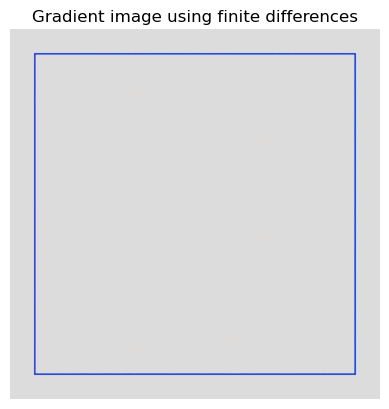

In [13]:
mi.Bitmap(img_fd).write("../results/grad/grad_fd.exr")
vlim = dr.max(dr.abs(img_fd))[0] * 1
plt.imshow(np.sum(img_fd, axis=2), cmap=cm.coolwarm, vmin=-vlim, vmax=vlim)
plt.title("Gradient image using finite differences")
plt.axis('off')
plt.show()

# Prb

In [14]:

# params[key] = initial_to_world # Load inital
init_scene(params)
params.update()

# dr.enable_grad(params)

x = mi.Float(0.0)
dr.enable_grad(x)
apply_translation_x(params, x)
dr.forward(x, dr.ADFlag.ClearEdges)

image = mi.render(scene, params = params, spp=1024)

mi.util.convert_to_bitmap(image)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [500, 500],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 732 KiB of image data ]
]

In [15]:
img_guided = dr.forward_to(image)

In [16]:
mi.Bitmap(img_guided).write("../results/grad/grad_camera.exr")
mi.util.convert_to_bitmap(img_guided)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [500, 500],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 732 KiB of image data ]
]

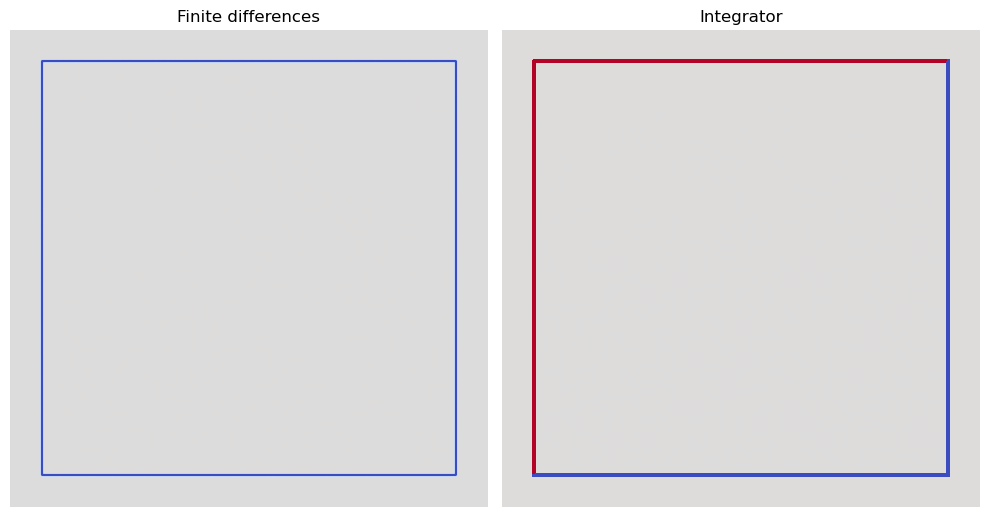

In [17]:
fig, axx = plt.subplots(1, 2, figsize=(10, 8))
vlim = dr.max(dr.abs(img_fd))[0] * 1
images = [img_fd, img_guided]
titles = ["Finite differences", "Integrator"]
for i, ax in enumerate(axx):
    ax.imshow(np.sum(images[i], axis=2), cmap=cm.coolwarm, vmin=-vlim, vmax=vlim)
    ax.set_title(titles[i])
    ax.axis('off')
fig.tight_layout()
plt.show()